In [1]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from mpl_toolkits.mplot3d import Axes3D

# Download and preprocess data

In [2]:
# MNIST Dataset transformation
mnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]
        self.imgs = [img for img, label in self.data]
        self.targets = [label for img, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=mnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0,8,4]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

Original size of the dataset:  60000
Filtered labels:  [0, 8, 4]
New size of the dataset:  17616


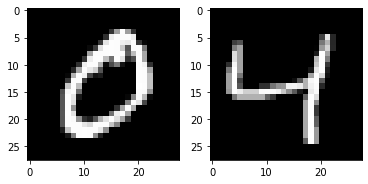

In [3]:
# show examples
fig,axs = plt.subplots(1,2)
axs[0].imshow(train_dataset[0][0].reshape(28, 28),cmap='gray')
axs[1].imshow(train_dataset[1][0].reshape(28, 28),cmap='gray')

# Train VAE RBFNN Model

## Initilize the VAE model

In [4]:
# model
input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [64, 32]  # The dimension of the hidden layers
latent_dim = 3  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation = nn.Sigmoid() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

# optimizer
lambda_reg = 1e-7 # weight decay (l2 regulariztaion to the losss)
learning_rate = 2e-4 #1e-3

# training
epochs = 400
warmup = int(0.33 * epochs)
batch_size = 256 #128

In [5]:
# initilize model
model = VAE.VAE(input_dim, 
                hidden_dims, 
                latent_dim, 
                hidden_activation, 
                encoder_output_mu_activation,
                encoder_output_logvar_activation,
                decoder_output_mu_activation,
                decoder_output_logvar_activation)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)
print(model)

VAE(
  (encoder): VAE_encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=32, out_features=3, bias=True)
      (1): Identity()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=32, out_features=3, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): VAE_decoder(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=64, out_features=784, bias=True)
      (1): Sigmoid()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=64, out_features=784, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
)


## Training of the VAE

[Epoch: 0/400] [objective loss: 287.589]
[Epoch: 20/400] [objective loss: 30.335]
[Epoch: 40/400] [objective loss: 29.739]
[Epoch: 60/400] [objective loss: 29.013]
[Epoch: 80/400] [objective loss: 28.670]
[Epoch: 100/400] [objective loss: 26.481]
[Epoch: 120/400] [objective loss: 26.789]
[Epoch: 140/400] [objective loss: 26.917]
[Epoch: 160/400] [objective loss: 26.383]
[Epoch: 180/400] [objective loss: 25.885]
[Epoch: 200/400] [objective loss: 25.359]
[Epoch: 220/400] [objective loss: 25.119]
[Epoch: 240/400] [objective loss: 25.027]
[Epoch: 260/400] [objective loss: 24.992]
[Epoch: 280/400] [objective loss: 24.940]
[Epoch: 300/400] [objective loss: 24.910]
[Epoch: 320/400] [objective loss: 24.819]
[Epoch: 340/400] [objective loss: 24.852]
[Epoch: 360/400] [objective loss: 24.794]
[Epoch: 380/400] [objective loss: 24.846]
[ELBO train: 24.8]
Training finished


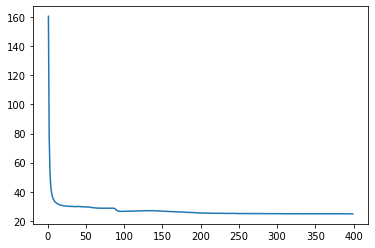

In [6]:
# Train the VAE with the new prior
ELBO_loss = []
for epoch in range(epochs):
    # Initialize the losses
    train_loss = 0.0

    for X_batch,y_batch in train_loader:
        # Forward pass
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(X_batch)

        # Compute the regluarization parameter for the warmup
        # that forces the latent variables to follow the prior distribution
        # see the code of VAE_loss for more informations
        r = min(1.0, epoch / warmup) if warmup > 0 else 0.0 

        # The VAE loss
        loss = VAE.VAE_loss(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                        mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, r=r)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss for the epoch
    average_epoch_loss = train_loss / len(train_loader)
    ELBO_loss.append(average_epoch_loss)

    if epoch % 20 == 0:
        print(f"[Epoch: {epoch}/{epochs}] [objective loss: {average_epoch_loss:.3f}]")
    
ELBO_train = round(ELBO_loss[-1], 2)
print(f'[ELBO train: {ELBO_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, epochs), ELBO_loss[1:])
# plt.xlabel('Epochs')
# plt.ylabel('ELBO Loss')
plt.show()

### Encode and decode the whole dataset

We need this so we can train the rbf using these output without re-forwarding inputs into the model

In [7]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

## Sanity check of the VAE

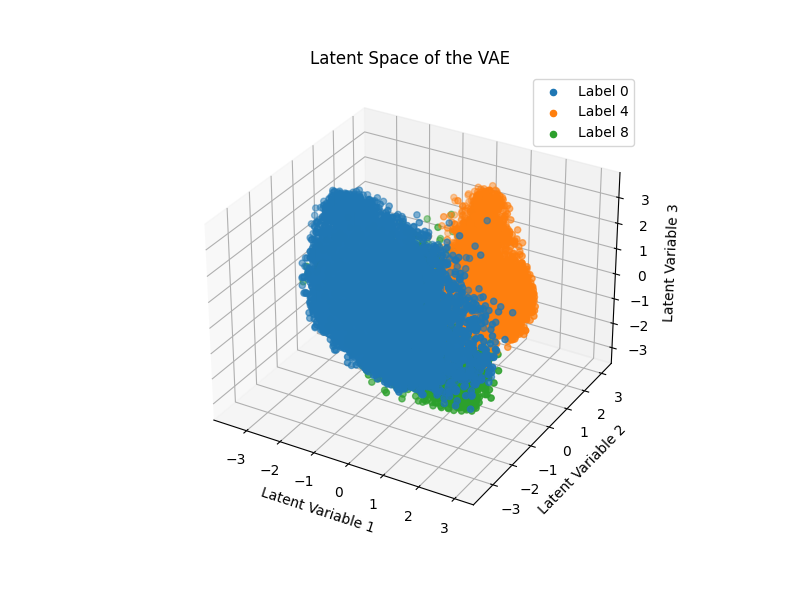

In [8]:
%matplotlib widget

# plot latent space
utils.plot_latent_space(latent_means,labels)

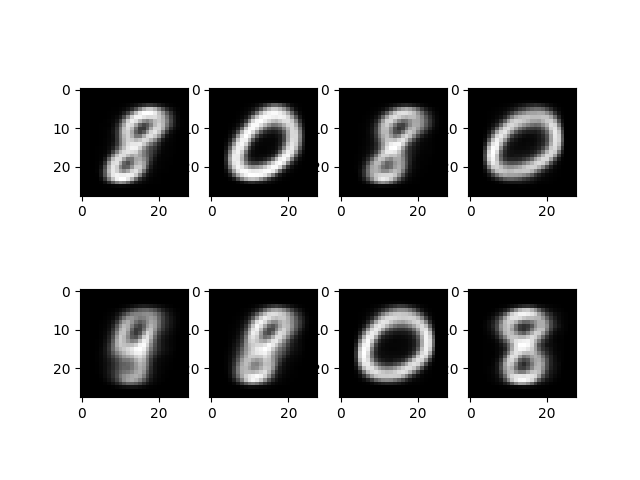

In [9]:
# display reconstructed output of the model
fig,axs = plt.subplots(2,4)
with torch.no_grad():
    for i in range(8):
        random_index = np.random.randint(0, len(train_dataset))
        pred = model(train_dataset[random_index][0].unsqueeze(0))[0] #just get mu_x
        axs[i//4,i%4].imshow(pred.reshape(28, 28),cmap='gray')

## Initialize the RBFN Model

### Create the RBF Network

Apply Kmeans to the latent space


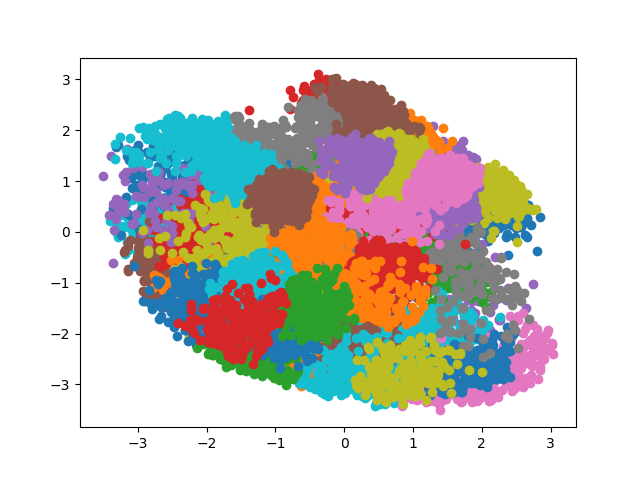

Compute the bandwidths for each centroids


In [10]:
# create RBF network
k_rbf = 64
a = 2
zeta_rbf = 1e-6
rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# apply kmeans to the means of the latent space
print("Apply Kmeans to the latent space")
plt.figure()
centers_rbf,centers_ids = rbfnn.fit_kmeans(latent_means,display=True)
# compute the bandwidths for each centroids
print("Compute the bandwidths for each centroids")
lambdas_k = rbfnn.compute_bandwidth(latent_means)

## Train the RBF Network

[iter: 0/300] [objective loss: 2.926507]
[iter: 20/300] [objective loss: 1.134373]
[iter: 40/300] [objective loss: 0.759079]
[iter: 60/300] [objective loss: 0.616043]
[iter: 80/300] [objective loss: 0.556248]
[iter: 100/300] [objective loss: 0.533003]
[iter: 120/300] [objective loss: 0.524158]
[iter: 140/300] [objective loss: 0.521887]
[iter: 160/300] [objective loss: 0.520921]
[iter: 180/300] [objective loss: 0.520553]
[iter: 200/300] [objective loss: 0.520318]
[iter: 220/300] [objective loss: 0.520637]
[iter: 240/300] [objective loss: 0.520479]
[iter: 260/300] [objective loss: 0.520351]
[iter: 280/300] [objective loss: 0.520462]
[ELBO train: 0.521016]
Training finished


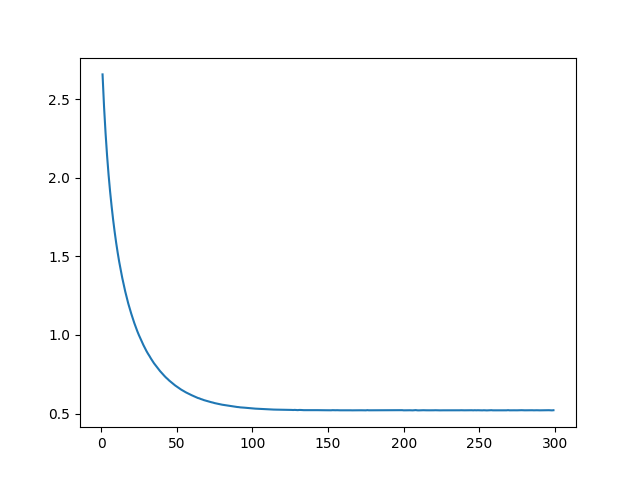

In [11]:
RBF_loss = []
nb_iters=300
optimizer_rbf = torch.optim.Adam(rbfnn.parameters(), lr=5e-4, weight_decay=1e-5)

for iter in range(nb_iters):
    # Initialize the losses
    train_loss = 0.0

    permutation = np.random.permutation(len(train_dataset))

    for i in range(0, len(train_dataset), batch_size):
        # Forward pass in the model
        indices = permutation[i:i + batch_size]
        # get previously computed latent means and logvars
        LOG_VAR_X = output_logvars[indices, :]
        MU_Z = latent_means[indices, :]
 
        # Regress the output of the variance network
        LOG_VAR_X_eval_RBF = -torch.log(rbfnn(MU_Z)) # = log(1/beta_psi(z)) to have logvar

        loss = torch.nn.MSELoss(reduction='mean')(LOG_VAR_X, LOG_VAR_X_eval_RBF)
             
        # Backward pass
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()

        # Ensure positivity of the weights
        rbfnn.W_rbf.data.clamp_(min=1e-5)
        train_loss += loss.item()

    # Average loss for the iter
    average_iter_loss = train_loss / len(train_loader)
    RBF_loss.append(average_iter_loss)

    if iter % 20 == 0:
        print(f"[iter: {iter}/{nb_iters}] [objective loss: {average_iter_loss:.6f}]")
    
RBF_train = round(RBF_loss[-1],6)
print(f'[ELBO train: {RBF_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, nb_iters), RBF_loss[1:])
plt.show()

# Save the trained models into a .pt

In [12]:
# combine both model into one torch module
vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
torch.save(vae_rbf_model.state_dict(), 'torch_models/VAE_RBFNN_3Dlatent.pt')